# Chinese Text Sentiment Analysis Based on Deep Learning

#### ***Label:***

$$positive->label('美味')=1$$
$$negative->label('难吃')=0$$

#### ***Flowchart:***
<center><img width=500 src="https://i.imgur.com/Ln5oRY1.png"></center>

## Import

In [132]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba  # jieba: Chinese words segmentation module
from gensim.models import KeyedVectors  # gensim: load the pre-trained word vector
import warnings
import os
warnings.filterwarnings("ignore")
import bz2  # unzip 
from sklearn.model_selection import train_test_split  # Split training and test samples
# using tensorflow's keras interface
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

## Load Pre-trained Word Vectors Model
###### In the word vector model, each word is an index, which corresponds to a vector of length 300. Since the LSTM neural network model does not directly process Chinese text, we need to first perform word separation operations and then convert the words into word vectors.

In [133]:
# Place the downloaded word vectors in the embeddings folder in the root directory and unzip
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [134]:
# Load pre-trained Chinese word separation embedding using gensim 
cn_model = KeyedVectors.load_word2vec_format('/content/embeddings/sgns.zhihu.bigram', binary=False, unicode_errors="ignore")

In [135]:
# Input a Chinese word and output a vector of words of length 300
embedding_dim = cn_model['青岛'].shape[0]
print('The length of the word vector is {}'.format(embedding_dim))
cn_model['青岛']

The length of the word vector is 300


array([ 8.375510e-01,  4.208510e-01, -2.799180e-01,  5.622690e-01,
       -8.997970e-01,  5.272690e-01,  9.496400e-01,  4.563700e-02,
       -9.810400e-02, -2.630750e-01, -1.524345e+00,  7.652050e-01,
       -1.986810e-01, -6.065320e-01,  5.041090e-01, -4.938500e-01,
        5.872340e-01, -1.234050e-01, -4.244760e-01,  1.889090e-01,
        7.961510e-01,  6.705470e-01,  7.920700e-02,  5.041190e-01,
       -5.473530e-01, -6.844260e-01,  4.471700e-01, -2.957340e-01,
       -2.229900e-01,  1.689930e-01,  3.720270e-01, -1.595700e-01,
       -3.491800e-02,  2.385590e-01, -2.851160e-01, -3.496570e-01,
       -2.146670e-01,  1.279030e-01,  1.851230e-01, -8.933700e-02,
       -3.738830e-01, -3.261810e-01,  8.310600e-02, -2.764490e-01,
        1.571830e-01, -6.430000e-03, -4.535830e-01,  3.596070e-01,
       -4.212470e-01,  4.759860e-01,  1.874830e-01, -1.392510e-01,
       -6.330000e-04,  1.503450e-01, -2.699750e-01, -3.896300e-02,
       -9.544230e-01,  1.075360e-01, -5.690130e-01,  5.670360e

In [136]:
# Calculate the cosine similarity of two words 
cn_model.similarity('英国', '伦敦')

0.55973804

In [137]:
# Input a Chinese word and find the 10 most similar words to it 
cn_model.most_similar(positive=['人民币'], topn=10)

[('美元', 0.7081582546234131),
 ('港币', 0.6911839842796326),
 ('日元', 0.6810632348060608),
 ('汇率', 0.679571270942688),
 ('欧元', 0.6542581915855408),
 ('欧元和', 0.6420362591743469),
 ('英镑', 0.6394895911216736),
 ('贬值', 0.636674165725708),
 ('韩元', 0.6353235840797424),
 ('卢布', 0.6327826976776123)]

In [138]:
# Enter a set of Chinese words and find the word that is not in the same category
test_words = '英国 德国 法国 中国 帅哥'
test_words_result = cn_model.doesnt_match(test_words.split())
print('In '+ '['+test_words+']' +':\nThe word that is not in the same category is: %s' %test_words_result)

In [英国 德国 法国 中国 帅哥]:
The word that is not in the same category is: 帅哥


**datasets**  
The datasets are placed in two separate .txt files: 
* <I>positive_samples.txt</I> (2000 Chinese positive reviews, label=1）
* <I>negative_samples.txt</I> (2000 Chinese negative reviews, label=0）

## Data Preprocessing 

In [139]:
train_texts_orig = []  # Store all reviews, one string per case
train_target = []  # Store all labels. The first 2,000 reviews are positive, the last 2,000 are negative. 
with open("datasets/positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("datasets/negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

In [140]:
print(len(train_texts_orig))
print(len(train_target))

4000
4000


**remove punctuation, jieba word segmentation and tokenize**  
* First we remove the punctuation from each sample. 
* Then using jieba word segmentation, which returns a generator -> cut. 
* However, the generator cannot be tokenized directly, so we also need to convert it to a list -> cut_list. 
* Next, Index it. 
* Finally, the text evaluated in each case becomes a segment of indexed numbers corresponding to the words in the pre-trained word vectors model.

In [141]:
train_tokens = []
for text in train_texts_orig:
    # Remove punctuation
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # jieba word segmentation
    cut = jieba.cut(text)  # jieba's output is a generator -> cut
    cut_list = [ i for i in cut ]  # Convert the generator to list -> cut_list 
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.key_to_index[word]  # Convert words to index
        except KeyError:
            cut_list[i] = 0  # If the word is not in the dictionary, output 0
    train_tokens.append(cut_list)  # train_tokens is a long list containing 4000 small lists, corresponding to each evaluation

**normalising index length**  
Because each review is of a different length, it would be a waste of computing resources to simply take the longest one and fill the others to the same length, so we take a compromise length.

In [142]:
# Get lengths of all tokens
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [143]:
# The average length of tokens
np.mean(num_tokens)

71.42575

In [144]:
# The longest tokens length
np.max(num_tokens)

1540

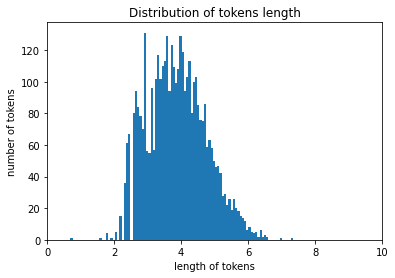

In [145]:
# Display the distribution of tokens length 
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [146]:
# Take the mean of tokens + standard deviation of tokens *2. The distribution of tokens lengths is approximated as a normal distribution
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [147]:
# When tokens are taken to be 236 in length, about 95% of the sample is covered. 
# (Under-length tokens will be padding and over-length tokens will be trimmed later)
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9565

**reverse tokenize**  
Define a function to convert the index into readable text, which is important for debugging.

In [148]:
# Convert tokens to text
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
#             text = text + cn_model.index2word[i]
            text = text + cn_model.index_to_key[i]
        else:
            text = text + ' '
    return text

In [149]:
# After tokenize and revert to text, the punctuation is gone
reverse = reverse_tokens(train_tokens[0])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [151]:
# original text
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

## Create the Embedding Matrix 

**create the embedding matrix**  
* Now, we need to create an embedding matrix. According to keras, we need to prepare a dimension of $(numwords, embedddingdim)$ of the matrix, where numwords represents the number of words we use, and emdeddingdim is 300 in the pre-trained word vector model we are using now, with each word represented by a vector of length 300.
* Note that we use only the first 50k most frequently used words. There are 2.6 million words in this pre-trained word vector model, and it would be a waste of computational resources to use them all for the classification problem.



In [152]:
embedding_dim

300

In [155]:
num_words = 50000  # Use only the first 50,000 words
embedding_matrix = np.zeros((num_words, embedding_dim))  # Initialise embedding_matrix
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')  # embedding_matrix is a matrix of [num_words, embedding_dim]. 
print('Dimension of embedding_matrix:', embedding_matrix.shape)  # Dimension of embedding_matrix

Dimension of embedding_matrix: (50000, 300)


**padding and truncating**  
After we convert the text into indexes, the length of each string of indexes is not equal, so in order to facilitate the training of the model, we need to normalise the length of the indexes. Above, we have chosen 236 samples, which can cover 95% of the length of the training samples.  
Next, we do padding and truncating. We generally use the 'pre' method, which will fill in the front of the text indexes with 0. Because, according to some research materials in practice, if you fill in the text indexes after 0, it will have some adverse effects on the model.

In [156]:
# Padding and truncating. The input train_tokens is a list, and the returned train_pad is a numpy array. 
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [157]:
# Words beyond the 50,000 word vector are replaced by 0
train_pad[ train_pad>=num_words ] = 0

In [158]:
# Fill in the front of the text index with 0. Text at the end
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [159]:
# create target labels, 1 for the first 2000 samples, 0 for the next 2000
train_target = np.array(train_target)

In [160]:
# 90% for training, 10% for test
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=12)

## Model Building 

Now we build the LSTM model using keras. The first layer of the model is the embedding layer, and only after we have transformed the token index into a word vector matrix can the text be processed by the neural network. Keras provides an embedding interface to avoid tedious sparse matrix operations.   
The matrix entered in the Embedding layer is: $$(batchsize, maxtokens)$$
The output matrix is: $$(batchsize, maxtokens, embeddingdim)$$

In [162]:
model = Sequential()

In [163]:
# The first layer of the model is embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

In [164]:
# 有兴趣的同学可以调整一下模型参数, 看看会不会有更好的结果
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

We tried several neural network structures, and because the training samples were relatively small, the training process did not take long to complete.
* GRU: The test samples could achieve 87% accuracy if GRU was used. However, when I tested my own text content, I found that the output of the last layer of the GRU activation function was all around 0.5, indicating that the model's judgement was not very clear, and after testing, I found that the model sometimes missed the judgement for negative sentences. We would expect the output to be close to 0 for negative samples and close to 1 for positive samples rather than hovering between 0.5.
* Single LSTM, stacked LSTM and BiLSTM: We tested both LSTM and BiLSTM and found that BiLSTM performed best, with LSTM performing slightly better than GRU, probably because BiLSTM has better memory for longer sentence structures.
* After Embedding the first layer we used BiLSTM to return sequences, then the second layer of 16 units of LSTM did not return sequences but only the final result, and finally a fully linked layer with a sigmoid activation function to output the result.

In [ ]:
# GRU code
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [165]:
model.add(Dense(1, activation='sigmoid'))

In [166]:
optimizer = Adam(lr=1e-3)

In [167]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [168]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 236, 128)          186880    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


## Model Training 

In [169]:
# Create a storage point for the weights
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [170]:
# Try to load a trained model
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [171]:
# Define early stopping. If the validation loss does not improve within 5 epochs then stop training
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [172]:
# Automatic learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [173]:
# Define the callback function
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [174]:
# Start training 
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Epoch 1/20
26/26 [==============================] - 63s 2s/step - loss: 0.3802 - accuracy: 0.8423 - val_loss: 0.3791 - val_accuracy: 0.8528

Epoch 00001: val_loss improved from inf to 0.37912, saving model to sentiment_checkpoint.keras
Epoch 2/20
26/26 [==============================] - 55s 2s/step - loss: 0.2996 - accuracy: 0.8821 - val_loss: 0.3279 - val_accuracy: 0.8611

Epoch 00002: val_loss improved from 0.37912 to 0.32787, saving model to sentiment_checkpoint.keras
Epoch 3/20
26/26 [==============================] - 55s 2s/step - loss: 0.2826 - accuracy: 0.8917 - val_loss: 0.3112 - val_accuracy: 0.8722

Epoch 00003: val_loss improved from 0.32787 to 0.31125, saving model to sentiment_checkpoint.keras
Epoch 4/20
26/26 [==============================] - 55s 2s/step - loss: 0.2770 - accuracy: 0.8917 - val_loss: 0.3519 - val_accuracy: 0.8583

Epoch 00004: val_loss did not improve from 0.31125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20

## Model Test

We start by making predictions on the test sample and get a good accuracy.


In [177]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

13/13 [==============================] - 2s 159ms/step - loss: 0.3188 - accuracy: 0.8700
Accuracy:87.00%


We then define a prediction function to predict the label of the input text. The results show that the model is accurate for negative sentences and simple logical structures.

In [201]:
def predict_sentiment(text):
    print(text, end=" ")
    # remove punctuation
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # word segmentation
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            # cut_list[i] = cn_model.vocab[word].index
            cut_list[i] = cn_model.key_to_index[word]
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # predict 
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        # print('-> prediction: positive','-> output=%.2f'%coef)
        print('-> output=%.2f'%coef, '-> positive')
    else:
        print('-> output=%.2f'%coef, '-> negative')

In [202]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好 -> output=0.15 -> negative
酒店卫生条件非常不好 -> output=0.12 -> negative
床铺非常舒适 -> output=0.65 -> positive
房间很凉，不给开暖气 -> output=0.18 -> negative
房间很凉爽，空调冷气很足 -> output=0.52 -> positive
酒店环境不好，住宿体验很不好 -> output=0.08 -> negative
房间隔音不到位 -> output=0.27 -> negative
晚上回来发现没有打扫卫生 -> output=0.19 -> negative
因为过节所以要我临时加钱，比团购的价格贵 -> output=0.11 -> negative


## Error Analysis 

Through our analysis, we find that the meaning of the misclassified text is mostly ambiguous, and even humans can not easily determine the polarity. For example, this sentence with index 305 seems to have no element of satisfaction at all, but this example rating is marked as positive in the training sample, and the prediction of a negative rating made by our model seems reasonable.

In [193]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [194]:
y_actual = np.array(y_test)

In [195]:
# indexes of misclassifications
misclassified = np.where( y_pred != y_actual )[0]
print('The misclassified indexes are as follows:\n', misclassified)

The misclassified indexes are as follows:
 [  1   5   7  14  15  21  30  52  59  72  73  80  81  90 101 118 123 127
 128 130 135 138 148 156 182 186 189 207 211 215 218 223 228 238 246 253
 258 267 283 297 302 305 311 316 335 342 352 365 373 390 391 394]


In [196]:
# total number of misclassifications
print('The total number of misclassifications is:', len(misclassified))

The total number of misclassifications is: 52


**output some misclassified samples**

In [203]:
idx=305
print('prediction', y_pred[idx])
print('groundtruth', y_actual[idx])
reverse_tokens(X_test[idx])

prediction 0
groundtruth 1


'                                                                                                                                                                                                            非常感谢携程  的客服人员帮助 了由客人自己信用卡担保的失误没有及时告知的事件下次有机会会再次光临本宾馆支持携程'

In [198]:
idx=394
print('prediction', y_pred[idx])
print('groundtruth', y_actual[idx])
reverse_tokens(X_test[idx])

prediction 1
groundtruth 0


'                                                                                                                                                                                                               服务员太差房间很吵隔音不好房间味道很重很一般不如稀土国际大酒店好收费有低还是 服务很好离火车站方便'

In [199]:
idx=15
print('prediction', y_pred[idx])
print('groundtruth', y_actual[idx])
reverse_tokens(X_test[idx])

prediction 1
groundtruth 0


'                                                                                                                                                                                                                                 招待所而已吧唯一可取之处就是交通还行三环边上'

In [200]:
idx=21
print('prediction', y_pred[idx])
print('groundtruth', y_actual[idx])
reverse_tokens(X_test[idx])

prediction 1
groundtruth 0


'                                                                                                                                                                                                      入住这个酒店应该算是被携程给误导了把它放在了第一选择位置如果酒店介绍加上 说明“  ”估计生意 了 还有  好好感谢携程'